In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("appliance_energy_usage.csv")
df.head()


,date,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Visibility
0,1/11/2016 17:00,60,30,6.600000,733.5,92.0,7.000000,5.3,63.000000
1,1/11/2016 17:10,60,30,6.483333,733.6,92.0,6.666667,5.2,59.166667
2,1/11/2016 17:20,50,30,6.366667,733.7,92.0,6.333333,5.1,55.333333
3,1/11/2016 17:30,50,40,6.250000,733.8,92.0,6.000000,5.0,51.500000
4,1/11/2016 17:40,60,40,6.133333,733.9,92.0,5.666667,4.9,47.666667


In [3]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

In [4]:
df

,Appliances,lights,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Visibility
date,,,,,,,,
2016-01-11 17:00:00,60,30,6.600000,733.5,92.000000,7.000000,5.300000,63.000000
2016-01-11 17:10:00,60,30,6.483333,733.6,92.000000,6.666667,5.200000,59.166667
2016-01-11 17:20:00,50,30,6.366667,733.7,92.000000,6.333333,5.100000,55.333333
2016-01-11 17:30:00,50,40,6.250000,733.8,92.000000,6.000000,5.000000,51.500000
2016-01-11 17:40:00,60,40,6.133333,733.9,92.000000,5.666667,4.900000,47.666667
...,...,...,...,...,...,...,...,...
2016-05-27 17:20:00,100,0,22.733333,755.2,55.666667,3.333333,13.333333,23.666667
2016-05-27 17:30:00,90,0,22.600000,755.2,56.000000,3.500000,13.300000,24.500000
2016-05-27 17:40:00,270,10,22.466667,755.2,56.333333,3.666667,13.266667,25.333333


In [5]:
df=df.loc[:,['lights']]
df=df.resample('1H').mean()

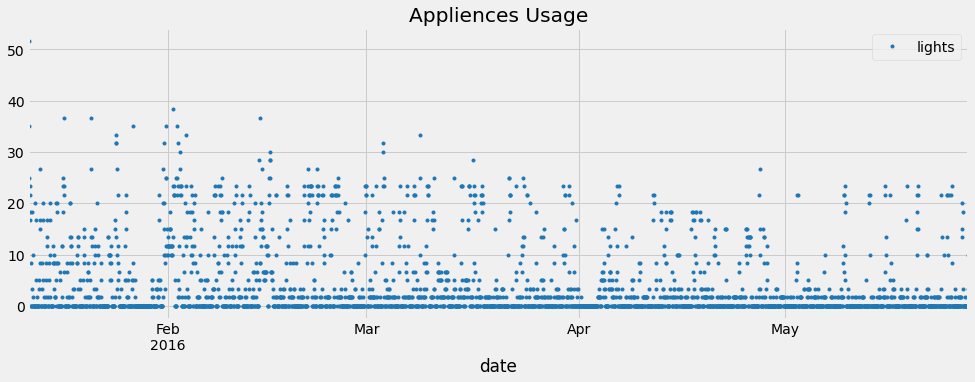

In [6]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Appliences Usage')
plt.show()

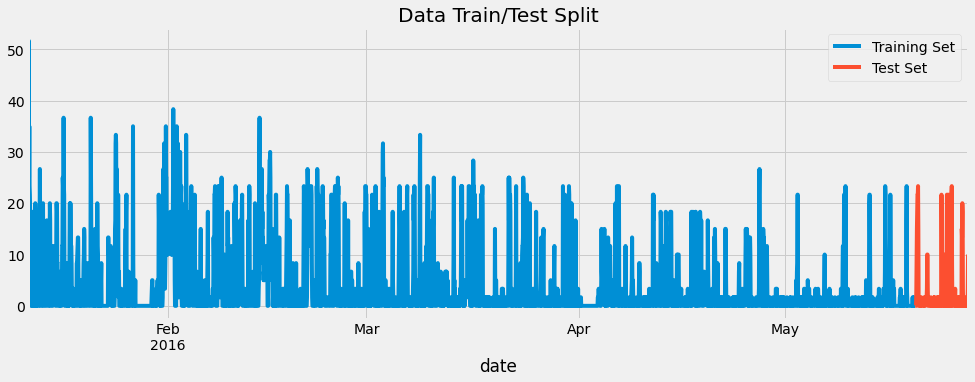

In [7]:
train=df[df.index<='2016-05-20 00:00:00']
test=df[df.index>='2016-05-20 01:00:00']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

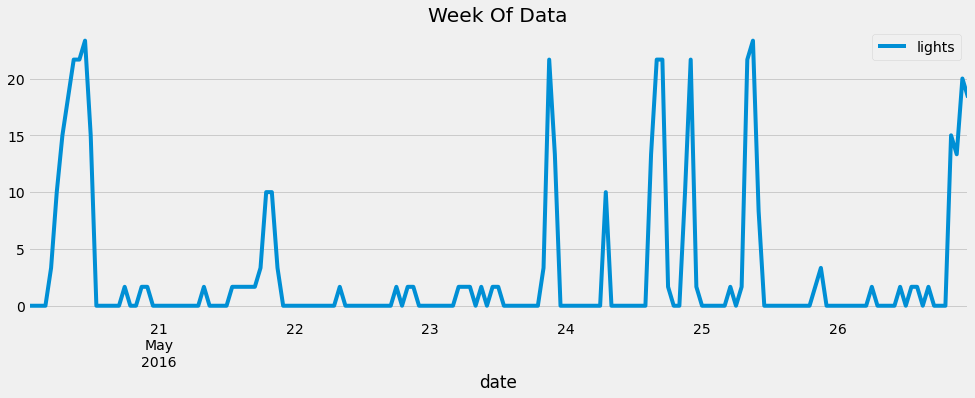

In [8]:
df.loc[(df.index > '20-05-2016') & (df.index < '27-05-2016')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

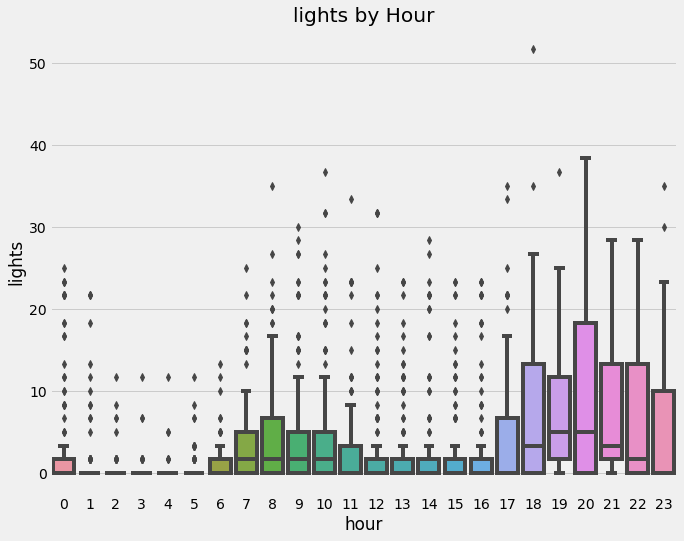

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='lights')
ax.set_title('lights by Hour')
plt.show()

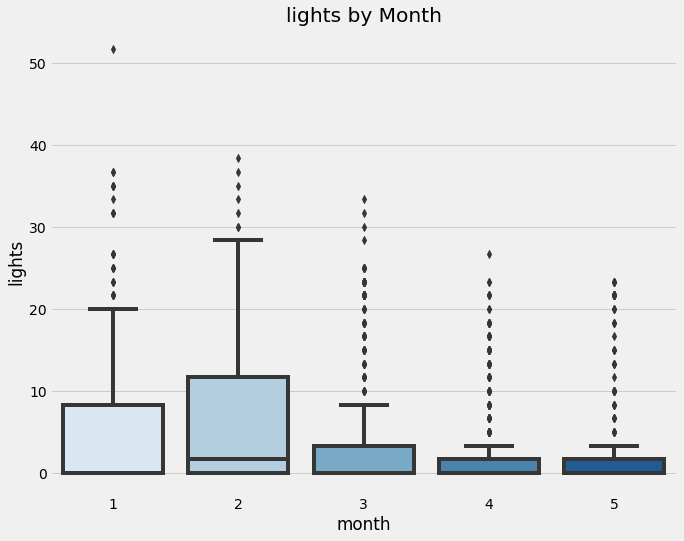

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='lights', palette='Blues')
ax.set_title('lights by Month')
plt.show()

In [12]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
#FEATURES = ['dayofyear', 'hour', 'dayofweek']
TARGET = 'lights'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=2000,
                       early_stopping_rounds=25,
                       objective='reg:squarederror',
                       max_depth=5,
                       learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:7.72634	validation_1-rmse:6.15656
[100]	validation_0-rmse:7.39613	validation_1-rmse:6.07639
[200]	validation_0-rmse:7.11218	validation_1-rmse:6.01651
[300]	validation_0-rmse:6.86667	validation_1-rmse:5.97144
[400]	validation_0-rmse:6.65130	validation_1-rmse:5.92892
[500]	validation_0-rmse:6.46454	validation_1-rmse:5.89858
[600]	validation_0-rmse:6.29948	validation_1-rmse:5.86894
[700]	validation_0-rmse:6.15521	validation_1-rmse:5.84229
[800]	validation_0-rmse:6.02695	validation_1-rmse:5.81661
[900]	validation_0-rmse:5.91322	validation_1-rmse:5.79468
[1000]	validation_0-rmse:5.80927	validation_1-rmse:5.77993
[1100]	validation_0-rmse:5.71752	validation_1-rmse:5.76803
[1200]	validation_0-rmse:5.63350	validation_1-rmse:5.75624
[1300]	validation_0-rmse:5.55554	validation_1-rmse:5.74848
[1400]	validation_0-rmse:5.48611	validation_1-rmse:5.74369
[1500]	validation_0-rmse:5.42679	validation_1-rmse:5.73692
[1600]	validation_0-rmse:5.37571	validation_1-rmse:5.73127
[1700]	va

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=25, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

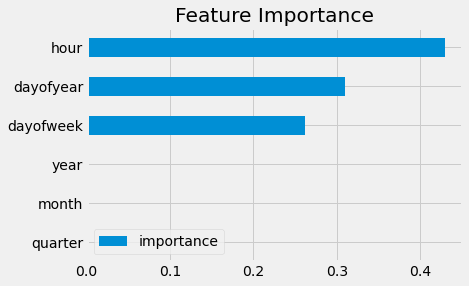

In [14]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

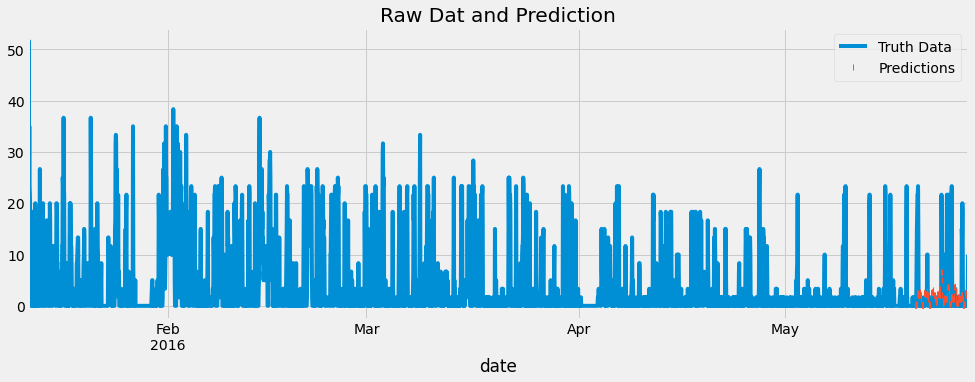

In [15]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['lights']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='|')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

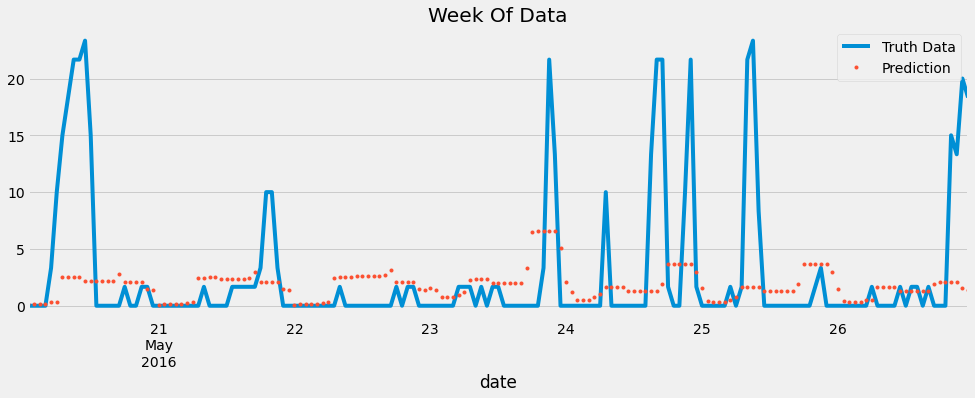

In [16]:
ax = df.loc[(df.index > '20-05-2016') & (df.index < '27-05-2016')]['lights'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '20-05-2016') & (df.index < '27-05-2016')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [19]:
score = np.sqrt(mean_squared_error(test['lights'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 5.72


In [18]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date2'] = test.index.date
test.groupby(['date2'])['error'].mean().sort_values(ascending=False).head(10)

date2
2016-05-20    5.731339
2016-05-24    4.674279
2016-05-26    3.368141
2016-05-25    3.297440
2016-05-23    2.824262
2016-05-27    1.879880
2016-05-21    1.654315
2016-05-22    1.450655
Name: error, dtype: float64